# HydroShoot: Polynomial transform benchmark

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

In [4]:
from model_config_hydroshoot import input_targets, output_targets


filename = 'results_hydroshoot_polynomial.csv'

data = pd.read_csv(filename, index_col=0)

targets = data['target_id'].unique().tolist()
reservoirs = data['reservoir_id'].unique().tolist()
datasets = data['dataset_id'].unique().tolist()
benchmarks = data['benchmark'].unique().tolist()

data = data.set_index(['target_id', 'reservoir_id', 'benchmark'])
data = data.sort_values(['target_id', 'reservoir_id', 'benchmark'], axis=0)

print(f'Available reservoir data: {reservoirs}')

Available reservoir data: ['state_An', 'state_E', 'state_Eabs', 'state_Ei', 'state_Flux', 'state_FluxC', 'state_Tlc', 'state_gb', 'state_gs', 'state_psi_head', 'state_u', 'state__het_all', 'env_all', 'env_temp', 'env_humidity', 'env_PAR', 'env_wind']


In [3]:
benchmarks = ['delay_line', 'near_future_pred', 'polynomial', 'NARMA']

bench_param = {
  'delay_line': 'delay',
  'near_future_pred': 'lookahead',
  'polynomial': 'exponent',
  'NARMA': 'narma_n',
}

bench_title = {
  'delay_line': 'Delay line',
  'near_future_pred': 'Near-future prediction',
  'polynomial': 'Polynomial transformation',
  'NARMA': 'NARMA benchmark',
}

bench_xlabel = {
  'delay_line': 'Delay (h)',
  'near_future_pred': 'Lookahead (h)',
  'polynomial': 'Polynomial degree',
  'NARMA': '$n$ parameter',
}

## Visualizations

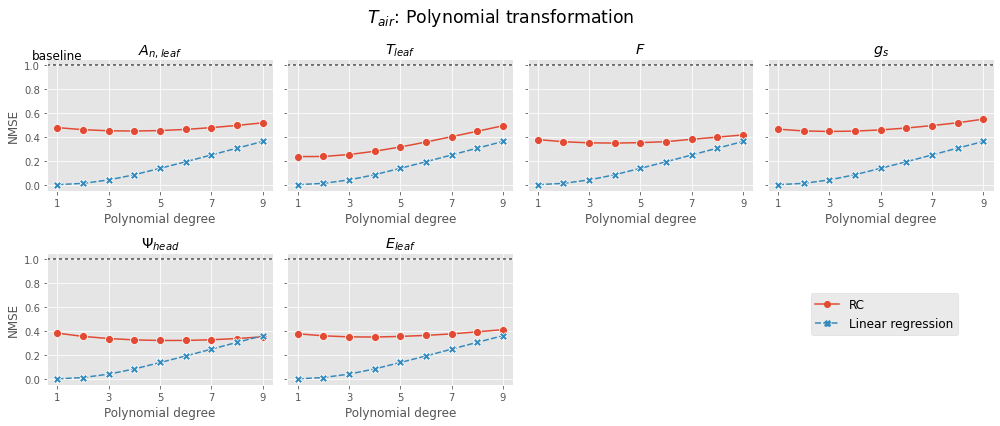

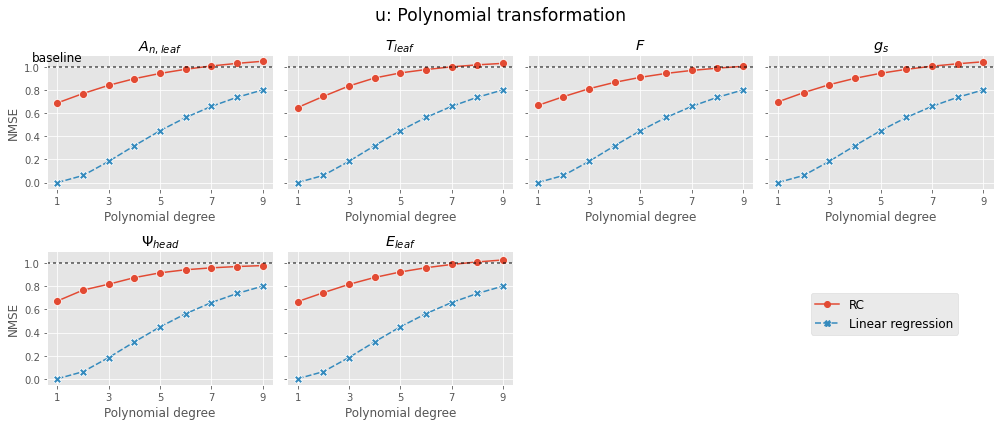

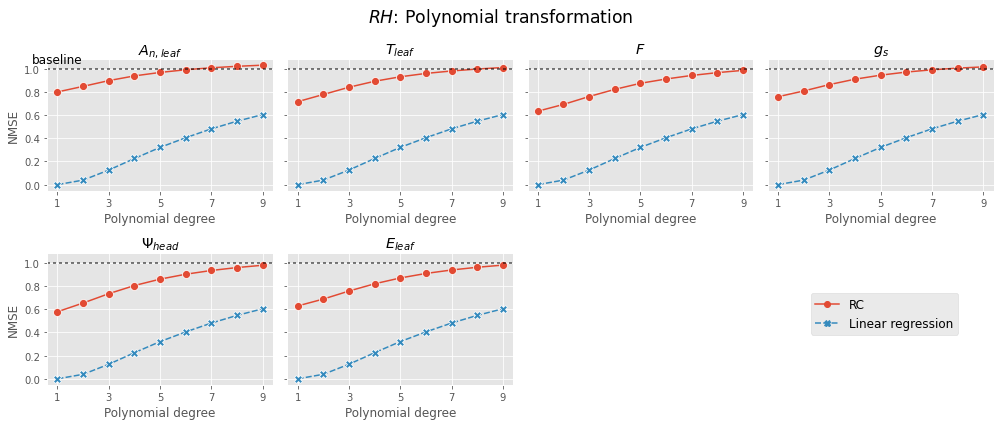

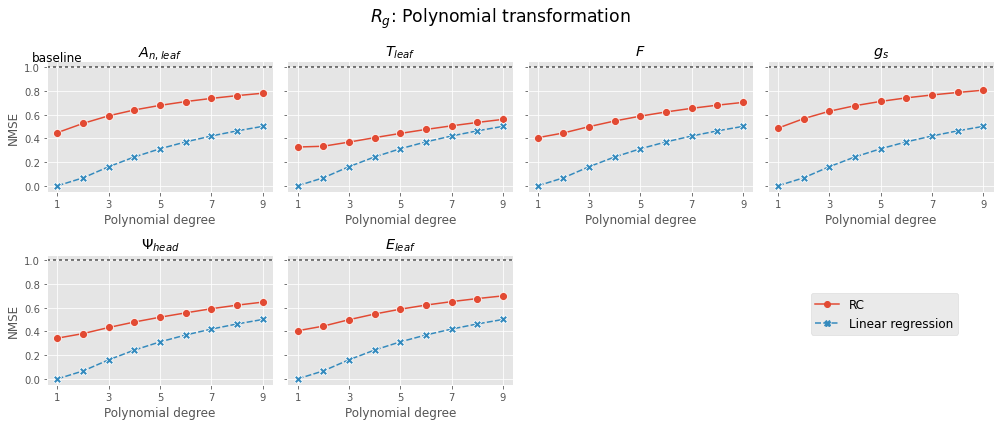

In [6]:
from model_config_hydroshoot import input_names, measurable_reservoirs, input_symbols, state_symbols, state_units, state_names


BENCHMARK = 'polynomial'
MAX_PARAM = 100


TARGETS = input_targets
BASELINE_RESERVOIRS = ['env_temp', 'env_wind', 'env_humidity', 'env_PAR']
PLANT_RESERVOIRS = measurable_reservoirs


for target, baseline_reservoir in zip(TARGETS, BASELINE_RESERVOIRS):
  with plt.style.context('ggplot'):
    # setup figure
    n_cols = 4
    n_rows = int(np.ceil(len(PLANT_RESERVOIRS) / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows), squeeze=False, sharey=True, sharex=False)

    # Filter and preprocess baseline data
    baseline_data = data.loc[target, baseline_reservoir, BENCHMARK].reset_index()
    baseline_data = baseline_data[baseline_data[bench_param[BENCHMARK]] <= MAX_PARAM]
    baseline_data['test_score'] *= -1
    baseline_data['reservoir_id'] = 'Linear regression'

    for reservoir, ax in zip(PLANT_RESERVOIRS, axs.flatten()):
      # filter and preprocess reservoir data
      plot_data = data.loc[target, reservoir, BENCHMARK].reset_index()
      plot_data = plot_data[plot_data[bench_param[BENCHMARK]] <= MAX_PARAM]
      plot_data['test_score'] *= -1
      plot_data['reservoir_id'] = 'RC'

      plot_data = pd.concat((plot_data, baseline_data), ignore_index=True)

      # create data plots
      sns.lineplot(x=bench_param[BENCHMARK], y="test_score", hue="reservoir_id", style="reservoir_id",
                   dashes=True, markers=True, data=plot_data, ax=ax, markersize=8)

      # plot baseline score dashed line
      ax.axhline(1, dashes=(2, 2), color='black', alpha=0.67)
      if ax is axs[0, 0]:
        ax.text(0, 1.05, 'baseline', fontsize='large', rotation='horizontal')

      # Figure ticks, labels and titles
      ax.set_xticks(np.arange(1, 10, 2))
      ax.set_xlabel(bench_xlabel[BENCHMARK])
      ax.set_ylabel("NMSE")
      ax.set_title(f'{state_symbols[reservoir]}')

      # Legend
      if ax is axs[0, 0]:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, bbox_to_anchor=(0.96, 0.33), fontsize='large')
      ax.legend_.remove()

    # Remove empty axes
    for ax in axs.flatten()[len(PLANT_RESERVOIRS):]:
      ax.remove()

    plt.suptitle(f'{input_symbols[target]}: {bench_title[BENCHMARK]}', fontsize='xx-large')
    plt.tight_layout()
    plt.savefig(os.path.join('figures/', f'hydroshoot__{BENCHMARK}__{target}.png'), dpi=200, bbox_inches='tight')

  